In [244]:
%matplotlib inline 
#widget
import sys 
import xarray as xr
import numpy as np
import os 
import warnings
import yaml
from random import randint
import math
from datetime import datetime, timedelta

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [245]:
config = ['/home/jvalenti/scratch/OParcels_runs/Parcels_outfall/outfall_runs.yaml']
path_runs = '/home/jvalenti/MOAD/results/Graham/' 
paths = path(0)
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

path_NEMO = make_prefix(datetime(2019, 1, 1),paths['NEMO'])
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [246]:
coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

In [247]:
def interpolate_to_grid(lat, lon, mask=mask):
    """
    Interpolate latitude and longitude to fractional grid coordinates in an irregular grid.

    Parameters:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        grid_lat (xarray.DataArray): Latitude values of the grid.
        grid_lon (xarray.DataArray): Longitude values of the grid.

    Returns:
        tuple: (x_grid, y_grid) as fractional grid coordinates.
    """
    grid_lat = mask.nav_lat
    grid_lon = mask.nav_lon
    distance = ((grid_lat - lat)**2 + (grid_lon - lon)**2)**0.5
    idx_min = distance.argmin()
    y_index, x_index = divmod(idx_min.values, grid_lon.shape[1])

    # Calculate fractional offsets (delta lat/lon to grid spacing)
    try: x_offset = (lon - grid_lon[y_index, x_index]) / (grid_lon[y_index, x_index + 1] - grid_lon[y_index, x_index])
    except IndexError:
        x_offset = (lon - grid_lon[y_index, x_index]) / (grid_lon[y_index, x_index - 1] - grid_lon[y_index, x_index])
    try:y_offset = (lat - grid_lat[y_index, x_index]) / (grid_lat[y_index + 1, x_index] - grid_lat[y_index, x_index])
    except IndexError:
        y_offset = (lat - grid_lat[y_index, x_index]) / (grid_lat[y_index - 1, x_index] - grid_lat[y_index, x_index])
    return float(x_index + x_offset), float(y_index + y_offset)

In [248]:
def finder2(target_lat, target_lon,mask=mask):
# Load grid data (e.g., from a NetCDF file)
    lat = mask.nav_lat
    lon = mask.nav_lon

    #find closest grid
    distance = ((lat - target_lat)**2 + (lon - target_lon)**2)**0.5
    nearest_index = distance.argmin()
    return int(nearest_index // lon.shape[1]), int(nearest_index % lon.shape[1])
     

Text(0.5, 1.0, 'Salish Sea subregions')

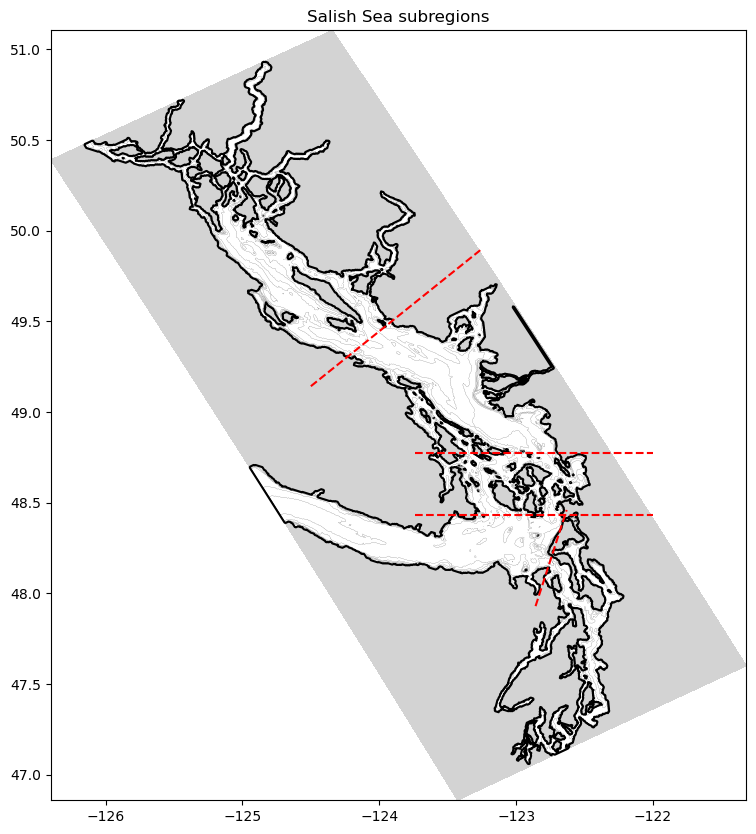

In [249]:
from matplotlib import pyplot as plt,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
#aa = ax.hist2d(DS.lon,DS.lat,100,cmap =cm,vmin=1e-5,vmax=2000)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
Xline = np.linspace(-124.5,-122,100)
yline0 = (7/3)*Xline+334.6
yline1 = (20/33)*Xline+124.597
yline2 = np.zeros_like(Xline)+48.43
yline3 = np.zeros_like(Xline)+48.774
plt.plot(Xline[65:75],yline0[65:75],'r--')
plt.plot(Xline[:50],yline1[:50],'r--')
plt.plot(Xline[30:],yline2[30:],'r--')
plt.plot(Xline[30:],yline3[30:],'r--')

plt.title('Salish Sea subregions')

In [250]:
import pandas as pd
Point_At = pd.read_csv('Book1.csv')
Time=np.linspace(0,365,8017)

Source = pd.read_csv('Outfall_deploy.csv')
Source = Source.rename(columns={'Lat': 'lat', 'Lon': 'lon'})

In [251]:
runs = {'250 s':['alpha120190101.nc',2],'500 s':['alpha_1_jan.nc',2],'1,000 s':['alpha220190101.nc',2],'2,500 s':['Runs_alpha0220190101_.nc',1],'5,000 s':['Run_Enero20190101_.nc',2],'10,000 s':['Runs_alpha0520190101_.nc',1],'50,000 s':['Runs_alpha0120190101_.nc',1]}

months = {'Jan':['Run_Enero20190101_.nc',1],'Feb':['Run_Febrero20190201_.nc',1],'Mar':['Run_Marzo20190301_.nc',1],'Jun':['Run_Junio20190601_.nc',1],'Jul':['Run_Julio20190701_.nc',1],'Aug':['Run_Agosto20190801_.nc',1]}

sub_areas=['Puget','JdF','Haro2','NSoG','CSSoG']
def cutting(data,area):
    if area=='Puget':
        data_new = data.loc[(data['lat']<48.43) & (data['lat']<(7/3)*data['lon']+334.6)]
    elif area=='JdF':
        data_new = pd.concat([data.loc[((data['lat']<48.43) & (data['lat']>(7/3)*data['lon']+334.6))],data.loc[((data['lat']>48.43) & (data['lat']<48.774) & (data['lon']<-124))]])
    elif area=='Haro':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-123.456) & (data['lon']<-123)]
    elif area=='Haro2':  
        data_new = data.loc[(data['lat']>48.43) & (data['lat']<48.774) & (data['lon']>-124)]
    elif area=='NSoG':
        data_new = data.loc[(data['lat']>(20/33)*data['lon']+124.597)]
    elif area=='CSSoG': 
        data_new = data.loc[(data['lat']>48.774)&(data['lat']<(20/33)*data['lon']+124.597)]
    else:
        print('Unrecognized subarea') 
        data_new = data
    return data_new

In [252]:
volume = (mask.e1t[0,:,:]*(mask.e2t[0,:,:])*(mask.e3t_0[0,:,:,:]))
maskt = mask.tmask[0,:,:,:]
total_volume = np.sum(maskt* volume)

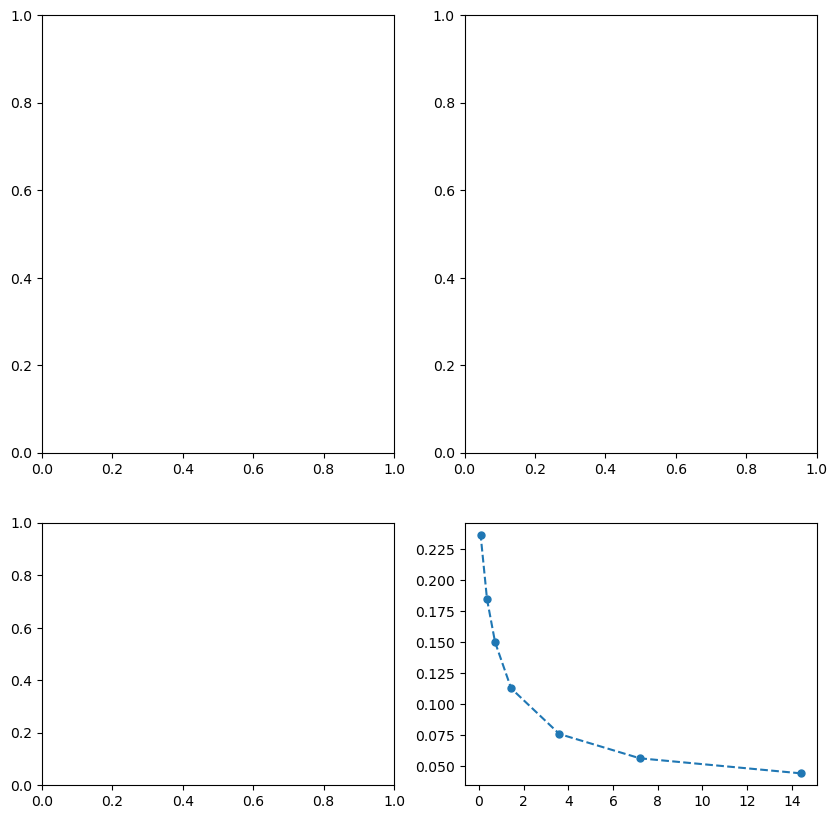

In [253]:
concs = {'250 s':['alpha120190101.npy',2],'500 s':['alpha_1_jan.npy',2],'1,000 s':['alpha220190101.npy',2],'2,500 s':['Runs_alpha0220190101_.npy',1],'5,000 s':['Run_Enero20190101_.npy',1],'10,000 s':['Runs_alpha0520190101_.npy',1],'50,000 s':['Runs_alpha0120190101_.npy',1]}

alphs = {'250 s':250,'500 s':500,'1,000 s':1000,'2,500 s':2500,'5,000 s':5000,'10,000 s':10000,'50,000 s':50000}
xs =np.array(list(alphs.values()))
masktt=maskt[:,::3,::3]
conc_mean = []
weighted_nanmean =[]
weighted_q1 = []
weighted_q3 = []
conc_sd = []
weights = mask.e3t_0[0,:,::3,::3]
TD = np.nansum(np.where(masktt,weights,np.nan).ravel())
weights = np.where(masktt,weights,np.nan)/TD
for alp in alphs:
    conc = np.load(path_runs+concs[alp][0])/concs[alp][1]
    conc = np.where(masktt,conc,np.nan)
    masknan = ~np.isnan(conc)
    data_cleaned = conc[masknan]
    weights_cleaned = weights[masknan]
    weighted_mean=np.average(data_cleaned, weights=weights_cleaned)
    weighted_nanmean.append(weighted_mean)
    #conc_mean.append(np.nanmean(np.nanmean(np.nanmean(conc,axis=2),axis=1)))
    #conc_sd.append(np.nanstd(np.nanstd(np.nanstd(conc,axis=2),axis=1)))
#plt.plot(xs, weighted_nanmean, '.', label="data")
fig,axs = plt.subplots(2,2,figsize=(10,10),height_ratios=[1, 0.6])
alphs = {'250 s':250,'500 s':500,'1,000 s':1000,'2,500 s':2500,'5,000 s':5000,'10,000 s':10000,'50,000 s':50000}
x = np.array(list(alphs.values()))
axes = fig.get_axes()
p0 = axes[3].plot(3600/x,weighted_nanmean,'.--',label = r'Concentration [MF m$^{-3}$]',markersize=10)
#axes[3].set_xscale('log')

In [254]:
import math

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    
    Parameters:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    
    Returns:
        Distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000 # Radius of Earth in kilometers
    return r * c

In [255]:
# travel_all = []
# for alpha in runs:
#     print(alpha)
#     ds = xr.open_dataset(path_runs+runs[alpha][0], decode_times=False)
#     x = np.linspace(0,31,ds.dims['obs']-1)
#     DS = ds.to_dataframe()
#     DS = DS.dropna()
    
#     dist_travel = []
#     for i in range(len(DS.lat)):
#         try: leni = len(DS.lat[i])
#         except KeyError:
#             break
#         dist_travel.append(haversine(DS.lat[i][0],DS.lon[i][0],DS.lat[i][leni-1],DS.lon[i][leni-1]))
#     travel_all.append(dist_travel)
# np.save('distance_travelled.npy',np.array(travel_all))

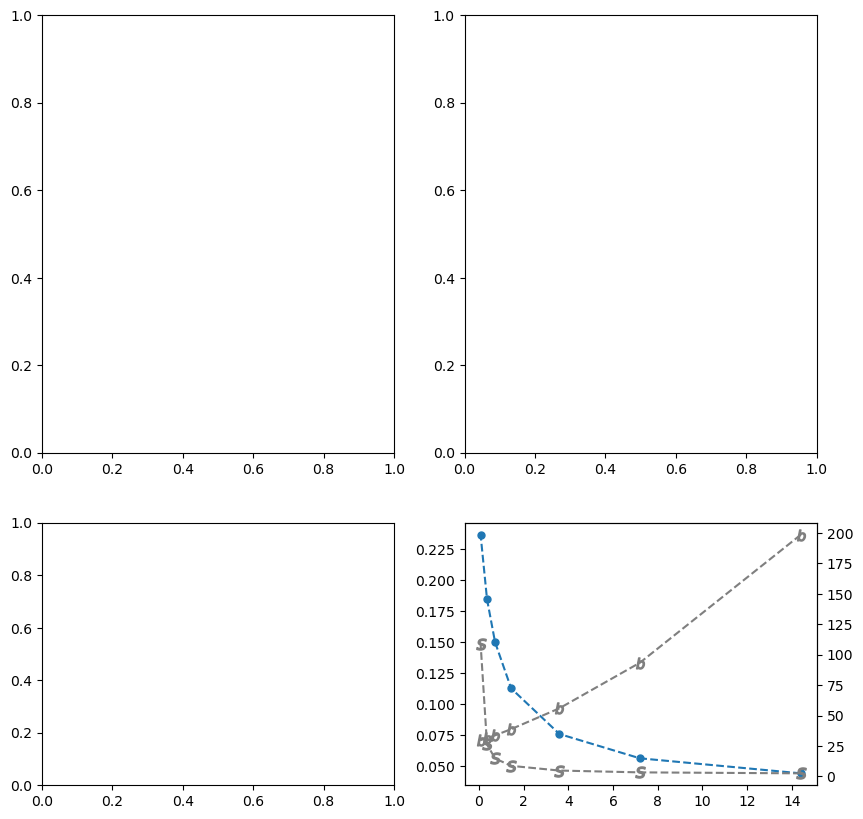

In [256]:
#np.save('sinkrates_alpha.npy',np.array(out))
axes4 = plt.twinx(axes[3])
out = np.load('sinkrates_alpha.npy')
beached = []
sedimented= []
for alpha in out:
    beached.append(alpha[0])
    sedimented.append(alpha[1])
p2 = axes4.plot(3600/x,np.array(beached),'--',c='tab:grey',label = r'Beaching rate [d$^{-1}$]',markersize=8,marker='$b$')
axes4.plot(3600/x,np.array(sedimented),'--',c='tab:grey',label = r'Sedimentation rate [d$^{-1}$]',markersize=8,marker = '$s$')

fig

In [257]:
a=[]
sd=[]
for alpha in alphs:
    a.append(np.mean(np.load('distance_travelled'+str(alpha)+'.npy'))/1e3)
    sd.append(np.std(np.load('distance_travelled'+str(alpha)+'.npy'))/1e3)

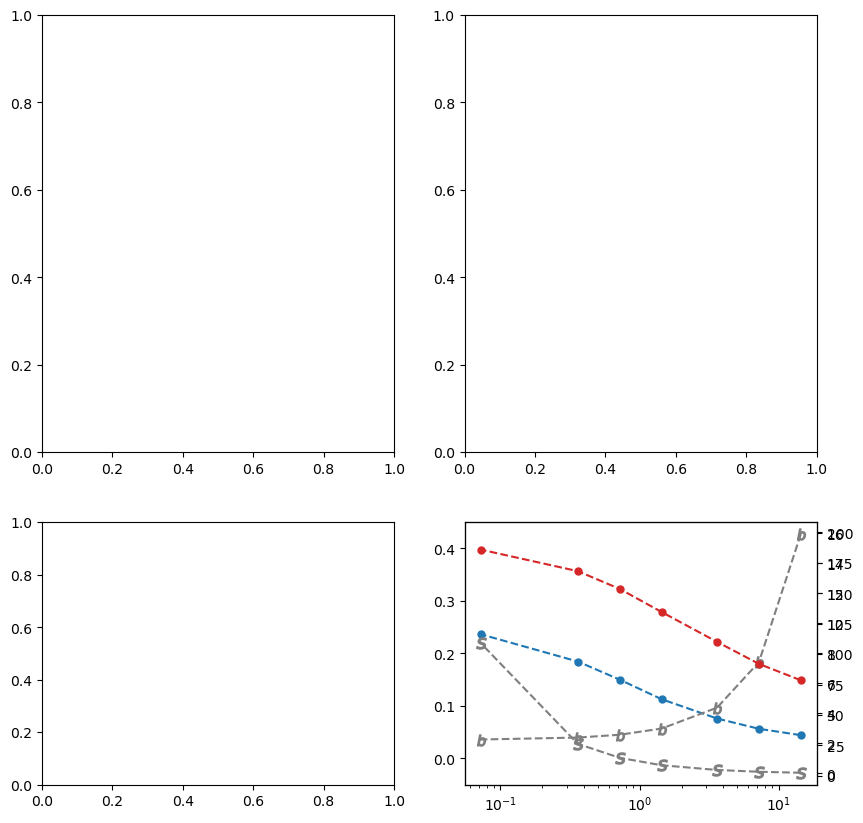

In [258]:
axes3 = plt.twinx(axes[3])
p1 = axes3.plot(3600/x,a,'.--',c='tab:red',label = r'Distance travelled [km]',markersize=10)
axes3.set_xscale('log')
handles0, labels0 = axes[3].get_legend_handles_labels()
handles, labels = axes3.get_legend_handles_labels()
handles1, labels1 = axes4.get_legend_handles_labels()
#axes[3].legend(handles=handles+handles0+handles1, labels=labels+labels0+handles1,loc=2)
axes[3].set_ylim(-0.05,0.45)
axes3.set_ylim(-0.75,16.75)
fig
#plt.errorbar(xs,a,yerr=sd)

In [259]:
maskbathy = np.where(masktt[0,:,:],mask.mbathy[0,::3,::3],np.nan)-1
maskbathy[np.isnan(maskbathy)]=0

In [260]:
conc = np.load(path_runs+concs[alp][0])/concs[alp][1]

In [261]:
# concs = {'250 s':['alpha120190101.npy',2],'500 s':['alpha_1_jan.npy',2],'1,000 s':['alpha220190101.npy',2],'2,500 s':['Runs_alpha0220190101_.npy',1],'5,000 s':['Run_Enero20190101_.npy',1],'10,000 s':['Runs_alpha0520190101_.npy',1],'50,000 s':['Runs_alpha0120190101_.npy',1]}

# months = {'Jan':['Run_Enero20190101_.npy',1],'Feb':['Run_Febrero20190201_.npy',1],'Mar':['Run_Marzo20190301_.npy',1],'Jun':['Run_Junio20190601_.npy',1],'Jul':['Run_Julio20190701_.npy',1],'Aug':['Run_Agosto20190801_.npy',1]}
# monthy = {'Jan':1,'Feb':2,'Mar':3,'Jun':6,'Jul':7,'Aug':8}


# conc_dep = []
# for alp in months:
#     conc = np.load(path_runs+months[alp][0])/months[alp][1]
#     conc = np.where(masktt,conc,np.nan)
#     for i in range(300):
#         for j in range(133):
#             conc[int(maskbathy[i,j]):,i,j]=np.nan
#     conc_dep.append(np.nanmean(np.nanmean(conc,axis=1),axis=1))#np.nanmean(np.nanmean(conc,axis=2),axis=1))
# X,Y =np.meshgrid(list(monthy.values()) ,mask.gdept_0[0,:,0,0])
# aa = axes[2].pcolormesh(X,Y,np.array(conc_dep).T,cmap=cmocean.cm.dense)
# levelsz =20+np.nanargmax(np.array(conc_dep)[:,20:],axis=1)
# zsub_max = []
# for zi in levelsz: 
#     zsub_max.append(mask.gdept_0[0,zi,0,0])
# sc= axes[2].scatter(np.array(list(monthy.values())),zsub_max,marker="*",c='r',label='Subsurface Max')

# axes[2].set_ylim(400,0)
# axes[2].set_xlim(3600/50050,3600/200)
# axes[2].legend(loc=3)
# fig

/tmp/ipykernel_2523412/4111488458.py:10: RuntimeWarning: Mean of empty slice
  conc_dep.append(np.nanmean(np.nanmean(conc,axis=1),axis=1))#np.nanmean(np.nanmean(conc,axis=2),axis=1))


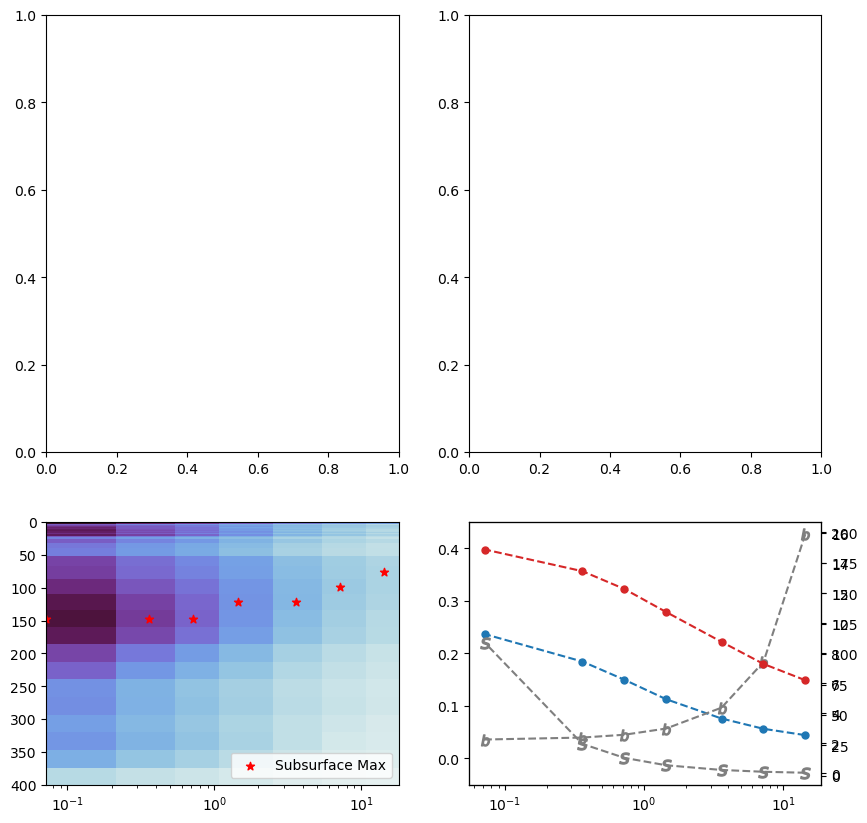

In [262]:
concs = {'250 s':['alpha120190101.npy',2],'500 s':['alpha_1_jan.npy',2],'1,000 s':['alpha220190101.npy',2],'2,500 s':['Runs_alpha0220190101_.npy',1],'5,000 s':['Run_Enero20190101_.npy',1],'10,000 s':['Runs_alpha0520190101_.npy',1],'50,000 s':['Runs_alpha0120190101_.npy',1]}

conc_dep = []
for alp in alphs:
    conc = np.load(path_runs+concs[alp][0])/concs[alp][1]
    conc = np.where(masktt,conc,np.nan)
    for i in range(300):
        for j in range(133):
            conc[int(maskbathy[i,j]):,i,j]=np.nan
    conc_dep.append(np.nanmean(np.nanmean(conc,axis=1),axis=1))#np.nanmean(np.nanmean(conc,axis=2),axis=1))
X,Y =np.meshgrid(list(alphs.values()) ,mask.gdept_0[0,:,0,0])
#aa = axes[2].contourf(3600/X,Y,np.array(conc_dep).T,cmap=cm)
aa = axes[2].pcolormesh(3600/X,Y,np.array(conc_dep).T,cmap=cmocean.cm.dense)
levelsz =20+np.nanargmax(np.array(conc_dep)[:,20:],axis=1)
zsub_max = []
for zi in levelsz: 
    zsub_max.append(mask.gdept_0[0,zi,0,0])
sc= axes[2].scatter(3600/np.array(list(alphs.values())),zsub_max,marker="*",c='r',label='Subsurface Max')
#axes[2].scatter(3600/np.array(list(alphs.values())),zsub_max2,marker="*",c='pink')
#axes[2].scatter(3600/np.array(list(alphs.values())),zsub_max3,marker="*",c='g')
#plt.xticks(3600/np.array(list(alphs.values())))
axes[2].set_ylim(400,0)
axes[2].set_xlim(3600/50050,3600/200)
axes[2].set_xscale("log")
axes[2].legend(loc=4)
#plt.title('effect of alpha average without last depth')
fig

In [263]:
ds = xr.open_dataset(path_runs+runs['250 s'][0], decode_times=False)
x = np.linspace(0,31,ds.dims['obs']-1)
DS = ds.to_dataframe()
DS = DS.dropna()
DS = DS[DS.time>0]
DS = DS[DS.status==3]

ds1 = xr.open_dataset(path_runs+runs['5,000 s'][0], decode_times=False)
DS1 = ds1.to_dataframe()
DS1 = DS1.dropna()
DS1 = DS1[DS1.time>0]
DS1 = DS1[DS1.status==3]

# months = {'Feb':['Run_Febrero20190201_.nc',1],'Mar':['Run_Marzo20190301_.nc',1],'Jun':['Run_Junio20190601_.nc',1],'Jul':['Run_Julio20190701_.nc',1],'Aug':['Run_Agosto20190801_.nc',1]}

# ds = xr.open_dataset(path_runs+'Run_Enero20190101_.nc', decode_times=False)
# DS3 = ds.to_dataframe()
# DS3 = DS3.dropna()
# DS3 = DS3[DS3.time>0]
# DS3 = DS3[DS3.status==3]

# countobs = 0
# for month in months:
#     ds = xr.open_dataset(path_runs+months[month][0], decode_times=False)
#     countobs += len(ds.obs)
#     DSN = ds.to_dataframe()
#     DSN = DSN.dropna()
#     DSN = DSN[DSN.time>0]
#     DSN = DSN[DSN.status==3]
#     DS3= pd.concat([DS3, DSN])

In [264]:
#Count all sedimented particles in the SoG
DScount = DS1[DS1.lat>48.774]
ii = []
for i,j in DScount.index:
    ii.append(i)
NF = len(set(ii))*5e6

#if we divide the whole set by 48 we get the same end result

In [265]:
#calculate the total area of SoG in the model
area = (mask.e1t[0,:,:]*(mask.e2t[0,:,:]))
maskt = mask.tmask[0,0,:,:]
maskt = np.where(mask.nav_lat<48.774,maskt,0)
total_area = np.sum(maskt* area)
concmf = NF/total_area

concmf/(0.0054)

<xarray.DataArray ()> Size: 8B
array(6365.83459697)

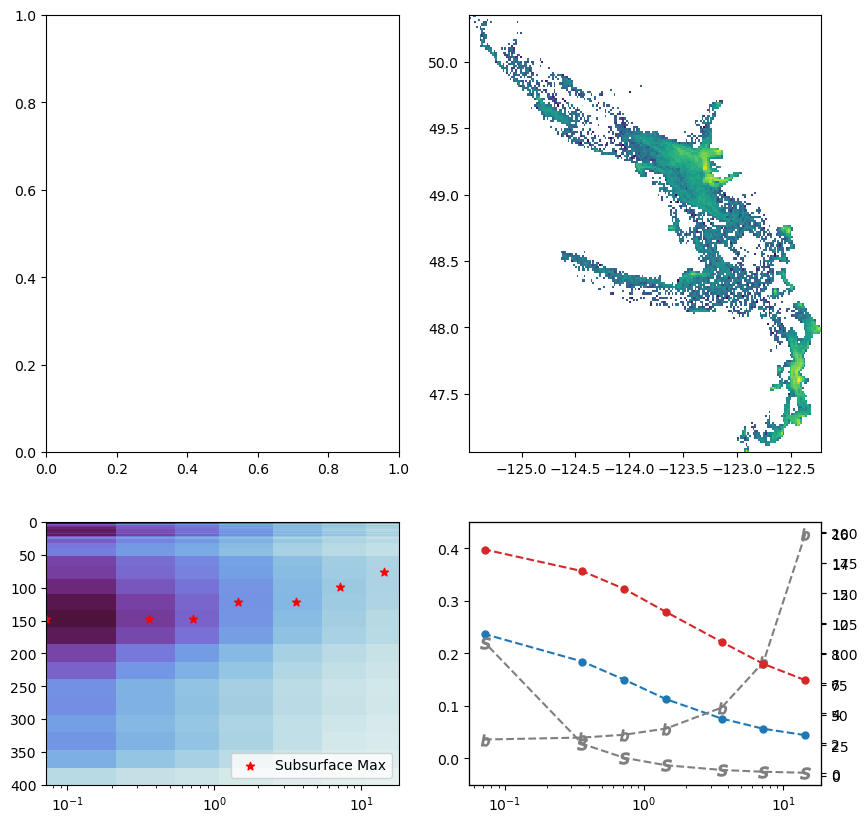

In [266]:
import cmocean
cm = cmocean.cm.matter
N = 200

h0, xedges, yedges, image0 = axes[0].hist2d(DS.lon,DS.lat,N,norm=colors.LogNorm())
axes[0].clear()
xlen = haversine(yedges[0], xedges[0], yedges[0], xedges[1])
ylen = haversine(yedges[0], xedges[0], yedges[1], xedges[0])

sarea = xlen*ylen
axes[0].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
axes[0].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
axes[0].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')


h0, xedges, yedges, image0 = axes[0].hist2d(DS.lon,DS.lat,N,weights=concs[alpha][1]*DS.status*5e6/(len(ds.obs)*3*sarea),cmap =cmocean.cm.thermal,norm=colors.LogNorm())
axes[0].set_xlim(-125.5,-122.25)
axes[0].set_ylim(48,50.5)
axes[0].clear()

vmax = np.max(h0)
h, xedges0, yedges0, image = axes[1].hist2d(DS1.lon,DS1.lat,[xedges, yedges],weights=concs[alpha][1]*DS1.status*5e6/(len(ds1.obs)*3*sarea),norm=colors.LogNorm())
fig

In [267]:
Xedges,Yedges = np.meshgrid(xedges,yedges)
ii_sed = np.zeros_like(Xedges)
jj_sed = np.zeros_like(Xedges)
for i in range(N):
    for j in range(N):
        jjj,iii = finder2(Yedges[i,j],Xedges[i,j])
        ii_sed[i,j]=iii
        jj_sed[i,j]=jjj

In [268]:
x = np.linspace(0,397,398)
y = np.linspace(0,897,898)
X, Y =np.meshgrid(x,y)
axes[0].clear()
axes[0].contourf(ii_sed[1:,1:],jj_sed[1:,1:], h0.T,norm=colors.LogNorm(vmin=1e-2, vmax=1e4),cmap = cmocean.cm.thermal)
axes[0].contour(X,Y, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
axes[0].contourf(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
axes[0].contour(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
f = 1.0/np.cos(49*np.pi/180)
axes[0].set_aspect(f)

axes[1].clear()
image = axes[1].contourf(ii_sed[1:,1:],jj_sed[1:,1:], (100*(h-h0)/h0).T,levels=np.linspace(-100,100,101),cmap = 'coolwarm')
axes[1].contour(X,Y, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
axes[1].contourf(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
axes[1].contour(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
#image=axes[1].pcolormesh(xedges, yedges, 100*(h-h0)/h0.T,cmap='coolwarm',vmin=-100,vmax=100)
axes[1].set_aspect(f)


/tmp/ipykernel_2523412/1893286303.py:5: UserWarning: Log scale: values of z <= 0 have been masked
  axes[0].contourf(ii_sed[1:,1:],jj_sed[1:,1:], h0.T,norm=colors.LogNorm(vmin=1e-2, vmax=1e4),cmap = cmocean.cm.thermal)
/tmp/ipykernel_2523412/1893286303.py:13: RuntimeWarning: divide by zero encountered in divide
  image = axes[1].contourf(ii_sed[1:,1:],jj_sed[1:,1:], (100*(h-h0)/h0).T,levels=np.linspace(-100,100,101),cmap = 'coolwarm')
/tmp/ipykernel_2523412/1893286303.py:13: RuntimeWarning: invalid value encountered in divide
  image = axes[1].contourf(ii_sed[1:,1:],jj_sed[1:,1:], (100*(h-h0)/h0).T,levels=np.linspace(-100,100,101),cmap = 'coolwarm')


In [269]:
cbar0 = plt.colorbar(image,ax=axes[1],pad=0.07,extend='both')
cbar0.set_label(r"% difference", fontsize=10)
cbar0.ax.yaxis.set_label_coords(0.1, 0.5)
cbar1 =plt.colorbar(image0,ax=axes[0],pad=0.07)#,orientation='horizontal')
cbar1.set_label(r"[MFm$^{-2}$]", fontsize=10)
cbar1.ax.yaxis.set_label_coords(0.05, 0.5)
cbar2 = plt.colorbar(aa,ax=axes[2],pad=0.07,aspect=10)#,orientation='horizontal
cbar2.set_label(r"[MFm$^{-3}$]", fontsize=10)
cbar2.ax.yaxis.set_label_coords(0.06, 0.5)

/tmp/ipykernel_2523412/2568098127.py:1: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 7 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar0 = plt.colorbar(image,ax=axes[1],pad=0.07,extend='both')
/tmp/ipykernel_2523412/2568098127.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 9 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar2 = plt.colorbar(aa,ax=axes[2],pad=0.07,aspect=10)#,orientation='horizontal


<Figure size 640x480 with 0 Axes>

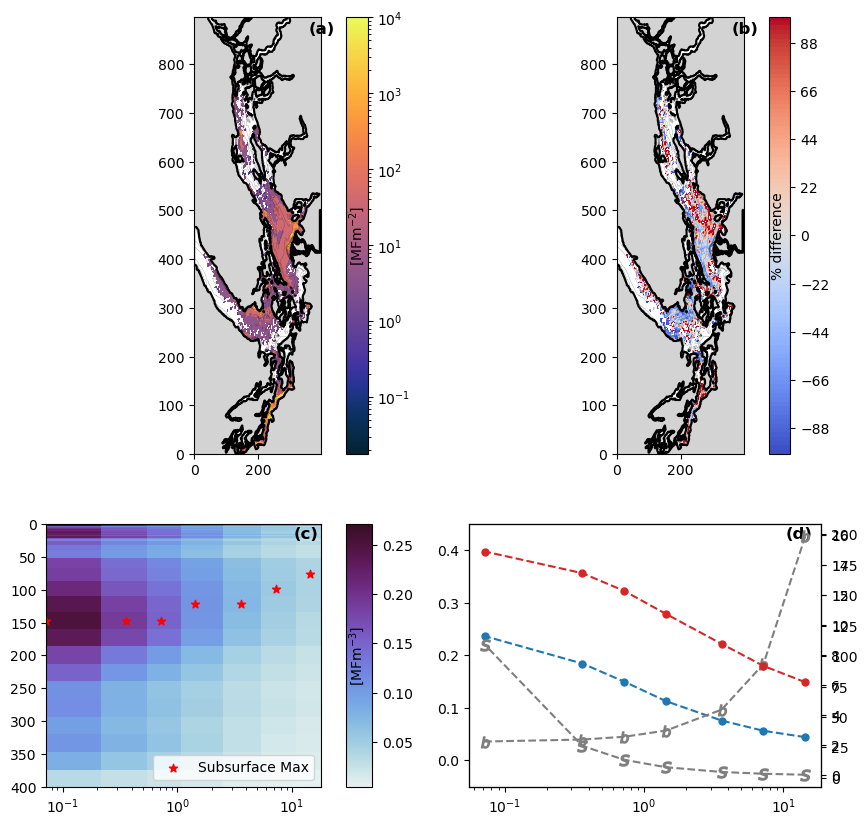

In [270]:
letters = ['(a)', '(b)', '(c)', '(d)']
for i in range(4):
    axes[i].text(0.9, 0.99, letters[i], transform=axes[i].transAxes, 
        fontsize=12, fontweight='bold', va='top')
fig

In [271]:
fig.subplots_adjust(wspace=0.3, hspace=0.1)
from matplotlib.ticker import FormatStrFormatter
axes[3].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].set_title(r'Sedimentation rate for $\alpha$ = 1.4 h')
axes[1].set_title(r'Sedimentation difference for $\alpha$: 0.06 vs 1.4 h')

axes[2].set_ylabel(r'Depth [m]')
axes[2].set_xlabel(r'1/$\alpha$ [h$^{-1}$]')
axes[3].set_ylabel(r'Mean concentration [MF m$^{-3}$]')
axes[3].set_xlabel(r'1/$\alpha$ [h$^{-1}$]')
axes3.set_ylabel(r'Mean distance travelled [km]')
axes4.set_ylabel(r'Sink timescale [d]')
axes4.set_ylim([-5,220])
axes4.spines['right'].set_position(('outward', 35))

axes[3].yaxis.label.set_color(p0[0].get_color())
axes3.yaxis.label.set_color(p1[0].get_color())
axes4.yaxis.label.set_color(p2[0].get_color())

In [272]:
#Here we squish the 4th pannel to have the same width as the rest
box = axes[3].get_position()
axes[3].set_position([box.x0, box.y0, box.width * 0.75, box.height])  # 

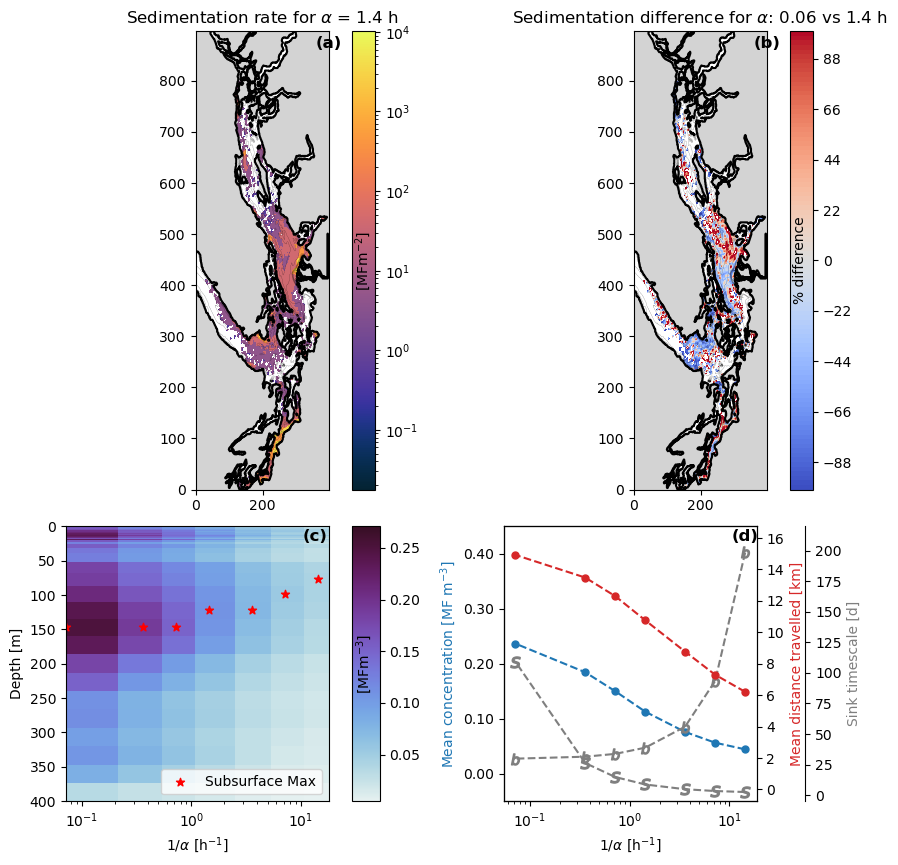

In [273]:
fig

In [274]:
fig.savefig('alphafig.pdf')

In [275]:
# def counting(DS,month,axs,fact=1,fact2 =1):
#     DSb = DS[DS.status==2]
#     DSe = DS[DS.status==3]
#     DSs = DS[DS.status==1]
#     count = []
#     countb = []
#     counte = []
#     depthb = []
#     for i in range(ds.dims['obs']-1):
#         times= np.min(DS.time)+i*6*3600
#         count.append(len(DSs[DSs.time == times]))
#         counte.append(len(DSe[DSe.time == times]))
#         countb.append(len(DSb[DSb.time == times]))
#         depthb.append(np.mean(DSs[DSs.time == times].z*DSs[DSs.time == times].fact))
#     axs[0,0].plot(x2,np.array(count)/fact,label = month)
#     axs[1,0].plot(x2,np.array(countb)/fact,'--',label = 'Beached')
#     twin3.plot(x2,np.array(counte)/fact,label = ' Sedimented')
#     axs[1,0].set_ylim([-1e4,6e4])
#     twin3.set_ylim([-1e4,6e4])
#     beached = [(c - countb[i-1])*4/(count[i-1]) for i,c in enumerate(countb)]#*4 to give the units in day-1
#     sediment = [(c - counte[i-1])*4/(count[i-1]) for i,c in enumerate(counte)]
#     beached = np.array(beached)
#     for i,b in enumerate(beached):
#         if b==0:
#             beached[i]=(beached[i-1]+beached[i+1])/2
#     sediment = np.array(sediment)
#     for i,b in enumerate(sediment):
#         if b==0:
#             sediment[i]=(sediment[i-1]+sediment[i+1])/2
#     axs[0,1].plot(moving_average(x2[1:],10),moving_average(1/beached[1:],10),'-',label = 'Beaching rate')
#     # twin1.plot(x2,depthb,'--',la(bel = 'Avg Depth')
#     axs[1,1].plot(moving_average(x[1:],10),moving_average(1/sediment[1:]/fact2,10),label = 'Sedimentation rate')
#     return np.mean(1/beached[1:]),np.mean(1/sediment[1:]/fact2)

In [276]:
# fig,axs = plt.subplots(2,2,figsize=(15,10))
# twin1 = axs[0,1].twinx()
# twin2 = axs[1,1].twinx()
# twin3 = axs[1,0].twinx()
# out = []
# #axs[1,1].plot(Time,np.array(Point_At.ssh[1:],dtype='f'),c='grey',alpha=0.4,label='SSH')
# for alpha in runs:
#     ds = xr.open_dataset(path_runs+runs[alpha][0], decode_times=False)
#     x = np.linspace(0,30,ds.dims['obs']-1)
#     x2 = np.linspace(0,30,ds.dims['obs']-1)
#     DS = ds.to_dataframe()
#     DS = DS.dropna()
#     DS = DS[DS.time>0]
#     out.append(counting(DS,alpha,axs))
# axs[0,0].legend()
# legend_lines = [plt.Line2D([0], [0], color='black', linestyle='-'),
#                 plt.Line2D([0], [0], color='black', linestyle='--')]
# axs[1,0].legend(legend_lines,['Sedimented','Beached'], loc = 'upper left')
# axs[0,1].legend(legend_lines,['Bch Rate','Avg Depth'], loc = 'center right')